<a href="https://colab.research.google.com/github/xymeo/mnist-handwriting-recognition/blob/main/handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader


In [2]:
mnist = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())

In [3]:
print('Mean {} \n Std: {}'.format(mnist.data.float().mean() / 255, mnist.data.float().std() / 255))


Mean 0.13066047430038452 
 Std: 0.30810779333114624


In [4]:
transform_set = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# transform_set = transforms.Compose([
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5), (0.5)),
#                              ])


In [5]:
training_set = datasets.MNIST(root="data", train=True, download=True, transform=transform_set) 

**Examining Sample Training Image** 

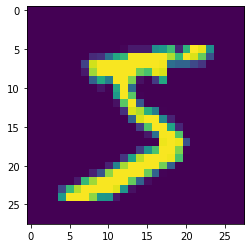

In [6]:
plt.imshow(training_set[0][0].squeeze());

torch.Size([1, 28, 28])


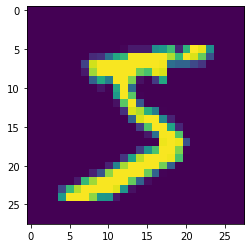

In [7]:
print(format(mnist[0][0].shape))
plt.imshow(mnist[0][0].squeeze());

In [8]:
validation_set = datasets.MNIST(root="data", train=False, download=True, transform=transform_set)

In [9]:
train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(validation_set, batch_size=64)


In [10]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


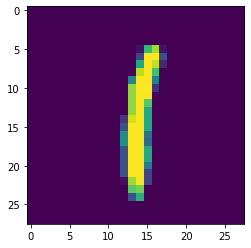

4


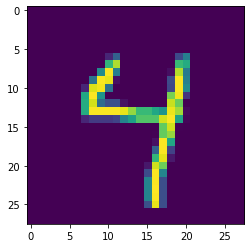

8


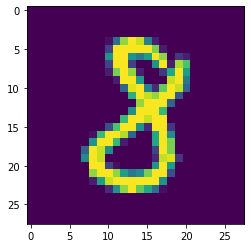

6


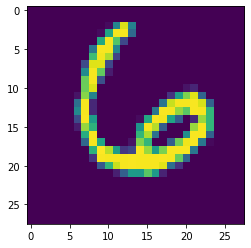

5


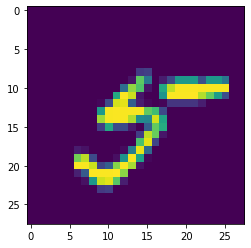

In [11]:
show5(train_loader)

Building the NN

In [12]:
class Net(nn.Module):
  def __init__(self):
     super().__init__()
     self.activation = F.relu
     self.hl1 = nn.Linear(28*28, 128)
     self.hl2 = nn.Linear(128, 64)
     self.hl3 = nn.Linear(64, 10)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.activation(self.hl1(x))
    x = self.activation(self.hl2(x))
    x = self.hl3(x)
    return x 

model = Net()


In [13]:
model 

Net(
  (hl1): Linear(in_features=784, out_features=128, bias=True)
  (hl2): Linear(in_features=128, out_features=64, bias=True)
  (hl3): Linear(in_features=64, out_features=10, bias=True)
)

**Optimizer and Loss Function**

In [14]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [15]:
num_epochs = 10

training_loss_history, val_loss_history = [], []
training_acc_history, val_acc_history = [], []

if torch.cuda.is_available():
  model = model.cuda()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0 # Number of correct predictions in training set
    training_acc = 0.0
    
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        if torch.cuda.is_available():  # Enable GPU if available
            inputs, labels = inputs.cuda(), labels.cuda()
            
        optimizer.zero_grad() # Set gradients of all weights to 0 
        outputs = model(inputs) # Get the output 
        loss = loss_function(outputs, labels) # Calculate loss agains labels 
        loss.backward() # Calculate dloss/dx for parameters x 
        optimizer.step() # Parameter update

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
      
    training_acc = train_correct * 100 /len(training_set)
    print(f'Epoch {epoch + 1} training accuracy: {training_acc:.2f}% training loss: {train_loss/len(training_set):.5f}')
    training_loss_history.append(train_loss/len(train_loader))
    training_acc_history.append(training_acc)

    val_loss = 0.0
    val_correct = 0 # Number of correct predictions in training set
    validation_acc = 0.0
    with torch.no_grad():
      model.eval()
      for inputs, labels in test_loader:
          if torch.cuda.is_available():
              inputs, labels = inputs.cuda(), labels.cuda()
          outputs = model(inputs) # Get output
          loss = loss_function(outputs, labels) 

          _, preds = torch.max(outputs.data, 1)
          val_correct += (preds == labels).sum().item()
          val_loss += loss.item()
    
    validation_acc = val_correct * 100 /len(validation_set)
    print(f'Epoch {epoch + 1} validation accuracy: {validation_acc:.2f}% validation loss: {val_loss/len(validation_set):.5f}')
    val_loss_history.append(val_loss/len(test_loader))
    val_acc_history.append(validation_acc)


100%|██████████| 938/938 [00:16<00:00, 55.26it/s]


Epoch 1 training accuracy: 78.43% training loss: 0.01279
Epoch 1 validation accuracy: 90.30% validation loss: 0.00534


100%|██████████| 938/938 [00:10<00:00, 86.47it/s]


Epoch 2 training accuracy: 91.04% training loss: 0.00488
Epoch 2 validation accuracy: 92.42% validation loss: 0.00417


100%|██████████| 938/938 [00:10<00:00, 86.41it/s]


Epoch 3 training accuracy: 92.64% training loss: 0.00399
Epoch 3 validation accuracy: 93.37% validation loss: 0.00357


100%|██████████| 938/938 [00:11<00:00, 82.20it/s]


Epoch 4 training accuracy: 93.68% training loss: 0.00342
Epoch 4 validation accuracy: 93.83% validation loss: 0.00328


100%|██████████| 938/938 [00:10<00:00, 85.92it/s]


Epoch 5 training accuracy: 94.49% training loss: 0.00299
Epoch 5 validation accuracy: 94.90% validation loss: 0.00277


100%|██████████| 938/938 [00:10<00:00, 86.23it/s]


Epoch 6 training accuracy: 95.11% training loss: 0.00265
Epoch 6 validation accuracy: 95.30% validation loss: 0.00256


100%|██████████| 938/938 [00:10<00:00, 85.85it/s]


Epoch 7 training accuracy: 95.64% training loss: 0.00236
Epoch 7 validation accuracy: 95.67% validation loss: 0.00228


100%|██████████| 938/938 [00:11<00:00, 83.53it/s]


Epoch 8 training accuracy: 96.09% training loss: 0.00213
Epoch 8 validation accuracy: 96.15% validation loss: 0.00208


100%|██████████| 938/938 [00:11<00:00, 85.20it/s]


Epoch 9 training accuracy: 96.48% training loss: 0.00193
Epoch 9 validation accuracy: 96.32% validation loss: 0.00196


100%|██████████| 938/938 [00:10<00:00, 85.67it/s]


Epoch 10 training accuracy: 96.71% training loss: 0.00177
Epoch 10 validation accuracy: 96.46% validation loss: 0.00186


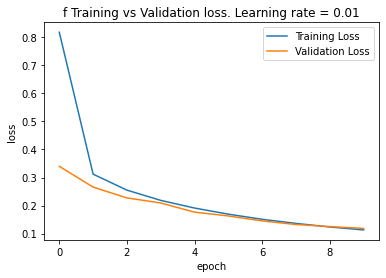

In [16]:
# Plot the training and validation loss history
plt.plot(training_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('f Training vs Validation loss. Learning rate = ' + format(learning_rate))
plt.legend()
plt.show()


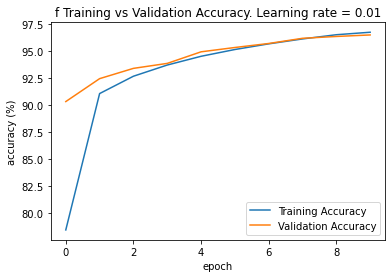

In [17]:
# Plot the training and validation loss history
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title('f Training vs Validation Accuracy. Learning rate = ' + format(learning_rate))
plt.legend()
plt.show()
